In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import pickle

In [2]:
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [3]:
path = os.path.join("..", "data", "cluster_df.pickle")
with open(path, "rb") as archivo:
    cluster_df = pickle.load(archivo).T

In [4]:
cluster_df = cluster_df.astype(pd.SparseDtype(np.float64, fill_value=0))

# Exploracion inicial

## Preparar matriz

In [140]:
cluster_df = cluster_df[cluster_df.sum(axis=1) > 0] # Muy importante, para no dividir por 0

# El porque algunos tienen 0, es o porque el anime que vieron no tenia tags, o habian visto algun anime que no sobrevivio la union MyAnimeList - AnimePlanet.
# Recuerden que si quieren ver el proceso de union, vean procesar_data.ipynb

In [5]:
# Hacer que todas las filas sumen 1
cluster_df_normal = cluster_df.sparse.to_dense()
cluster_df_normal = cluster_df_normal.div(cluster_df_normal.sum(axis=1), axis=0)

# No, yo tampoco sabia esto, y si, fue hecho por copilot.
# Dataframe.div basicamente divide cada serie de una axis de un dataframe, por una serie con los mismos indices de la axis.
# En este caso, se usa la axis de la fila (axis=0), y se divide por la serie de sumas de filas
# Y eso hace que todo sume 1.

In [6]:
matriz = cluster_df_normal.to_numpy()
matriz

## Numero de componentes

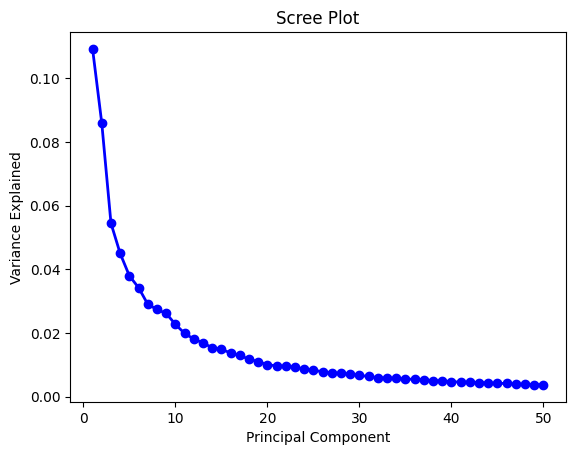

In [8]:
pca = PCA(n_components=200)
pca.fit(matriz)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(range(1,50 + 1), pca.explained_variance_ratio_[0:50], 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

El metodo del codo diria que tenemos que usar aproximadamente 7 componentes

## KMeans

In [ ]:
from sklearn.cluster import KMeans

inertia = []
kmax = 100

# entrenamiento y evaluación
for i in range(1,kmax + 1):
    # modelo
    kmeans = KMeans(n_clusters=i, n_init='auto')
    nCluster = kmeans.fit(X)

    print(i, nCluster.inertia_)
    inertia.append(nCluster.inertia_)

1 53.466351960263964
2 45.40456001292926
3 40.183821885754995
4 37.260434679944055
5 35.05497206335995
6 32.310047433888926
7 30.79212428571468
8 29.247162452008695
9 27.759907518815034
10 26.205948094758693
11 25.215684856536512
12 24.746063613886204
13 23.6317035096461
14 22.987601308616593
15 22.41166629931857
16 21.94205450668102
17 21.21136499956556
18 20.73551830246631
19 20.756369793619825
20 19.89611725209814
21 19.93636089524315
22 19.671126293865722
23 18.982532705853345
24 18.670679768832795
25 18.17079320497028
26 17.965090980977564
27 17.736311830097215
28 17.412510651308562
29 17.31788326280766
30 17.054811673253425
31 16.86063904519769
32 16.54891312914029
33 16.311112851300816
34 16.00979612884208
35 15.925835886216433
36 15.960424798572264
37 15.64056327226016
38 15.445563041631406
39 15.382603687398586
40 15.291534772503372
41 14.974696191985707
42 15.061723384942518
43 14.64980590911313
44 14.614390473821555
45 14.338930499733948
46 14.30671513539453
47 14.1473350312

Text(0.5, 1.0, 'K-means - Método del codo')

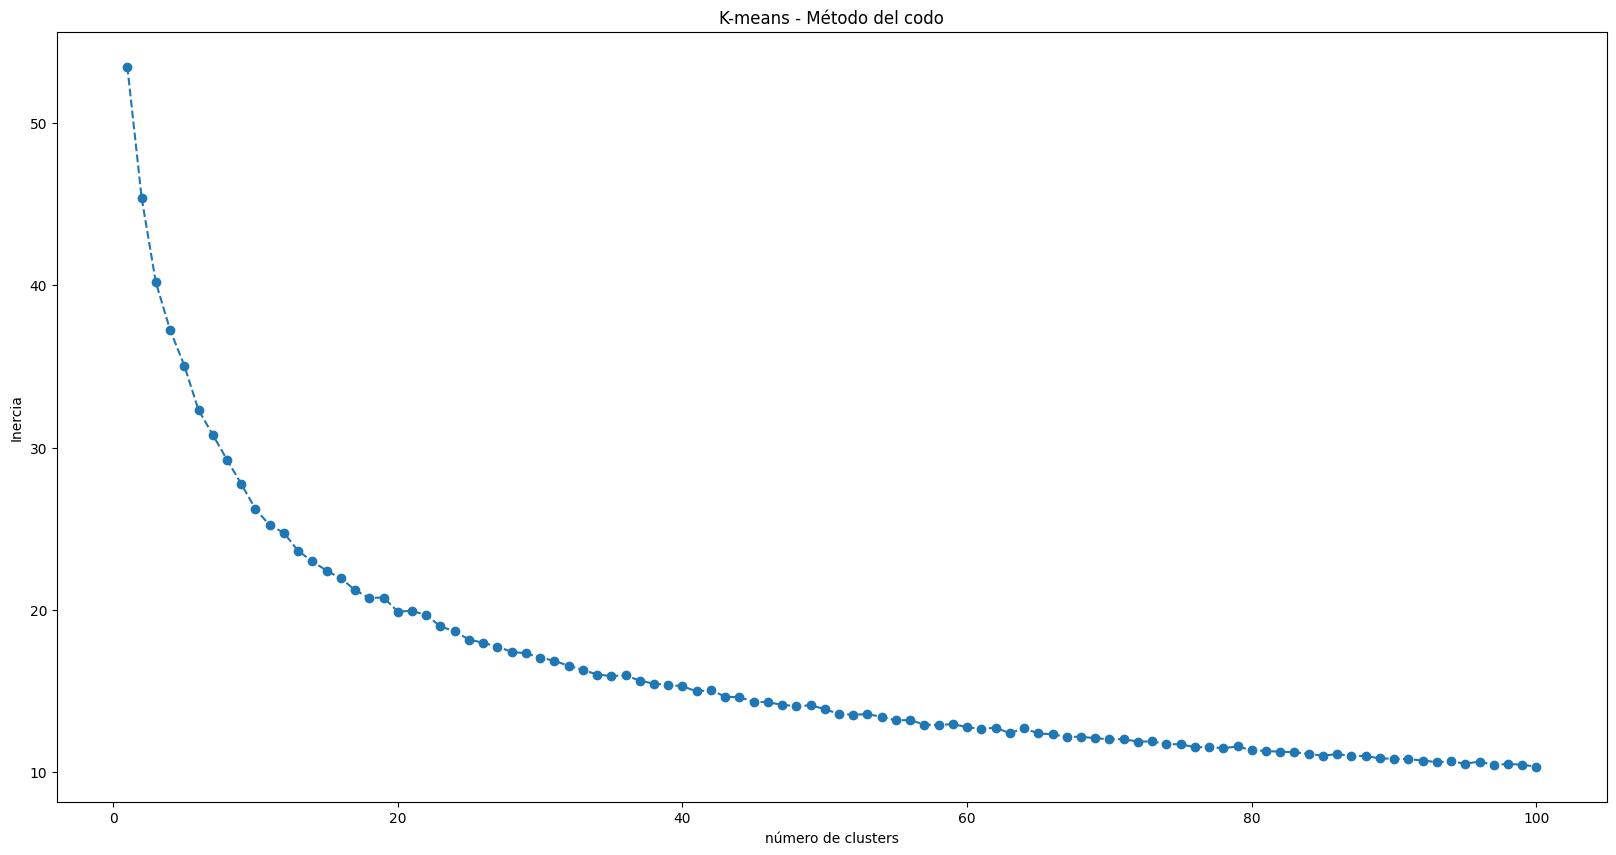

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

ax.plot(range(1, kmax + 1), inertia, marker='o', ls='--')
ax.set_xlabel('número de clusters')
ax.set_ylabel('Inercia')
ax.set_title('K-means - Método del codo')

Por metodo del codo unos 20 clusters tiene sentido

# Iteracion Rapida

## Definir metodos

In [17]:
def to_df(matriz, grupos, indexes, columns):
    df = pd.DataFrame(matriz, index=indexes, columns=columns)
    df["grupo"] = grupos
    return df

def gustos_anime(df, grupo, cantidad):
    df_copy = df.copy()
    df_copy["grupo"] = grupo
    agrupado = df_copy.groupby("grupo").mean()
    for index, grupo in agrupado.iterrows():
        print(f"{index}:\n{grupo.sort_values(ascending=False).head(cantidad)}\n")

def eficiencia(data, grupos):
    print(f"Silhouette score, mas cercano a 1 es mejor: {silhouette_score(data, grupos)}")
    print(f"Davies Bouldin score, mas cercano a 0 es mejor: {davies_bouldin_score(data, grupos)}")
    print(f"Calinski Harabasz score, mayor es mejor: {calinski_harabasz_score(data, grupos)}")

def plot_pca(df, x, y, z, c):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')

    Xax = df[x]
    Yax = df[y]
    Zax = df[z]
    Gax = df[c]

    norm=plt.Normalize(Gax.min(), Gax.max()) # El rango de valores para el colormap

    for l in sorted(Gax.unique()):
        ix = Gax == l
        ax.scatter(Xax[ix], Yax[ix], Zax[ix], cmap="gist_ncar", norm=norm, c=Gax[ix], alpha=1, s=12, label=l)

    ax.set_xlabel(x, fontsize=12)
    ax.set_ylabel(y, fontsize=12)
    ax.set_zlabel(z, fontsize=12)
    
    ax.view_init(30, 125)
    ax.legend()
    plt.title("3D PCA plot")
    plt.show()

## Iterar

In [31]:
cluster_df_normal = cluster_df.copy()

cluster_df_normal = cluster_df_normal.drop(columns=["Based on a Manga", "Original Work", "Based on a Light Novel"])
cluster_df_normal = cluster_df_normal[cluster_df.sum(axis=1) > 0]
cluster_df_normal = cluster_df_normal.sparse.to_dense()
# Normalizar suma a 1
# cluster_df_normal = cluster_df_normal.div(cluster_df_normal.sum(axis=1), axis=0)
# Normalizar norma a 1
cluster_df_normal = cluster_df_normal.div((cluster_df_normal.iloc[0,] ** 2).sum()**0.5, axis=0)
matriz = cluster_df_normal.to_numpy()

0:
Action           0.071669
Shounen          0.060998
Drama            0.051708
Fantasy          0.045105
Comedy           0.042105
Mature Themes    0.035672
School Life      0.034682
Violence         0.033726
Supernatural     0.032086
Romance          0.027731
Name: 0, dtype: float64

1:
Action          3.852421
Comedy          3.334748
Shounen         2.709838
Fantasy         2.659310
Drama           2.485554
School Life     2.242010
Romance         1.999446
Violence        1.688908
Supernatural    1.554177
Sci Fi          1.546479
Name: 1, dtype: float64

2:
Action          2.146361
Shounen         1.392941
Fantasy         1.350218
Comedy          1.239065
Drama           1.191897
Violence        0.955366
School Life     0.831229
Sci Fi          0.801866
Adventure       0.793239
Supernatural    0.780832
Name: 2, dtype: float64

3:
Comedy          5.446166
Action          4.724353
School Life     3.621560
Fantasy         3.582424
Shounen         3.486605
Romance         3.318393
Dra

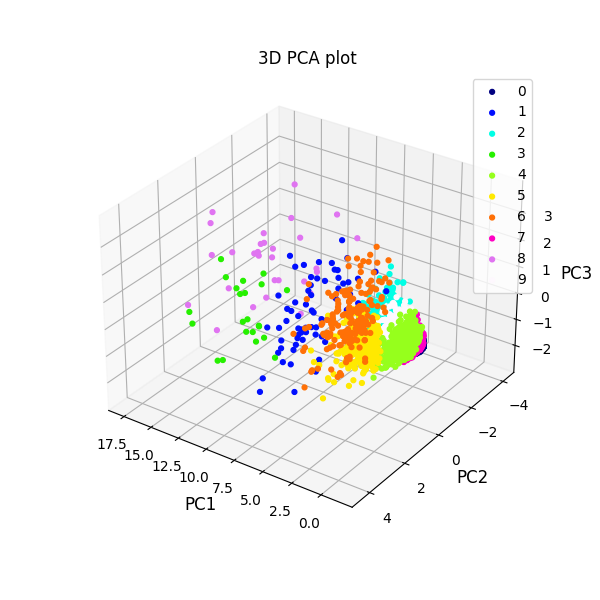

In [32]:
componentes = 3
grupos = 10

# Hacer reduccion de dimensionalidad
# pca = KernelPCA(n_components=componentes, kernel='rbf', gamma=0.1)
pca = PCA(n_components=componentes)

pca.fit(matriz)
X = pca.transform(matriz)

# Hacer clustering
kmeans = KMeans(n_clusters=grupos, n_init='auto')
kmeans.fit(matriz)
G = kmeans.predict(matriz)



X_df = to_df(X, G, indexes=cluster_df_normal.index, columns=[f"PC{i}" for i in range(1, componentes + 1)])
gustos_anime(cluster_df_normal, G, 10)

%matplotlib widget
plot_pca(X_df, "PC1", "PC2", "PC3", "grupo")

En esta se normalizo las filas de forma que sus normas sumen 1, y se hizo que el KMeans use la misma matriz. Sin embargo esto no funciona, ya que los resultados son muy parejos.

## iteracion 2

In [33]:
cluster_df_normal = cluster_df.copy()

cluster_df_normal = cluster_df_normal.drop(columns=["Based on a Manga", "Original Work", "Based on a Light Novel"])
cluster_df_normal = cluster_df_normal[cluster_df.sum(axis=1) > 0]
cluster_df_normal = cluster_df_normal.sparse.to_dense()
# Normalizar suma a 1
# cluster_df_normal = cluster_df_normal.div(cluster_df_normal.sum(axis=1), axis=0)
# Normalizar norma a 1
cluster_df_normal = cluster_df_normal.div((cluster_df_normal.iloc[0,] ** 2).sum()**0.5, axis=0)
matriz = cluster_df_normal.to_numpy()

0:
Action           0.070118
Shounen          0.059690
Drama            0.050442
Fantasy          0.044386
Comedy           0.040881
Mature Themes    0.035060
School Life      0.033858
Violence         0.032970
Supernatural     0.031497
Romance          0.026994
Name: 0, dtype: float64

1:
Action          3.412582
Fantasy         2.213719
Shounen         2.201729
Comedy          2.143836
Drama           1.877786
Violence        1.479113
School Life     1.367969
Sci Fi          1.310932
Adventure       1.263110
Supernatural    1.237333
Name: 1, dtype: float64

2:
Action           1.253538
Shounen          0.875476
Fantasy          0.765854
Drama            0.757078
Comedy           0.752293
Violence         0.579828
School Life      0.528595
Supernatural     0.483894
Mature Themes    0.476451
Sci Fi           0.458493
Name: 2, dtype: float64

3:
Comedy          3.911286
Action          3.858472
Shounen         2.862560
Fantasy         2.790827
Drama           2.655048
School Life     2.

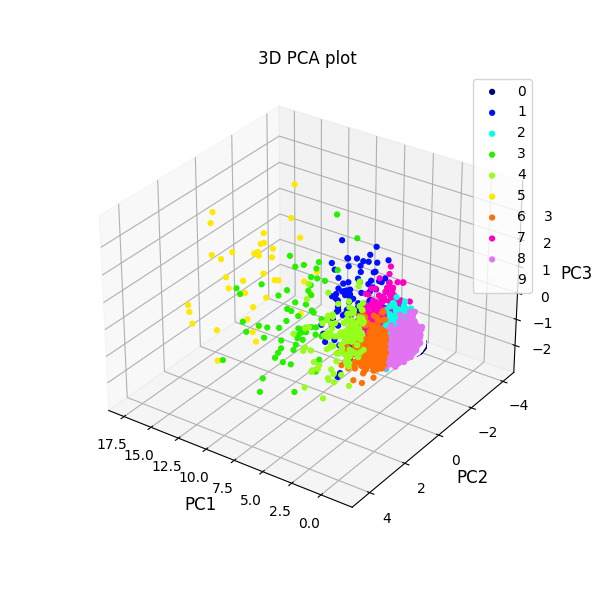

In [34]:
componentes = 3
grupos = 10

# Hacer reduccion de dimensionalidad
# pca = KernelPCA(n_components=componentes, kernel='rbf', gamma=0.1)
pca = PCA(n_components=componentes)

pca.fit(matriz)
X = pca.transform(matriz)

# Hacer clustering
kmeans = KMeans(n_clusters=grupos, n_init='auto')
kmeans.fit(X)
G = kmeans.predict(X)



X_df = to_df(X, G, indexes=cluster_df_normal.index, columns=[f"PC{i}" for i in range(1, componentes + 1)])
gustos_anime(cluster_df_normal, G, 10)

%matplotlib widget
plot_pca(X_df, "PC1", "PC2", "PC3", "grupo")

## iteracion 3

In [35]:
cluster_df_normal = cluster_df.copy()

cluster_df_normal = cluster_df_normal.drop(columns=["Based on a Manga", "Original Work", "Based on a Light Novel"])
cluster_df_normal = cluster_df_normal[cluster_df.sum(axis=1) > 0]
cluster_df_normal = cluster_df_normal.sparse.to_dense()
# Normalizar suma a 1
cluster_df_normal = cluster_df_normal.div(cluster_df_normal.sum(axis=1), axis=0)
matriz = cluster_df_normal.to_numpy()

0:
Shounen                0.148217
Action                 0.147998
Ninja                  0.117967
Drama                  0.112076
Revenge                0.099568
Orphans                0.060212
Rivalries              0.059888
Japanese Mythology     0.059888
Hand to Hand Combat    0.048114
Fantasy                0.043388
Name: 0, dtype: float64

1:
Action               0.049675
Shounen              0.037585
Drama                0.034675
Mature Themes        0.029285
Violence             0.026005
Supernatural         0.025885
Fantasy              0.024088
Sci Fi               0.022010
Psychological        0.021555
Explicit Violence    0.020523
Name: 1, dtype: float64

2:
Romance            0.114343
Drama              0.090105
School Life        0.086494
Comedy             0.069677
Shounen            0.028097
Supernatural       0.024575
Romantic Comedy    0.020516
Seinen             0.019394
Harem              0.019250
School Club        0.017401
Name: 2, dtype: float64

3:
Action       

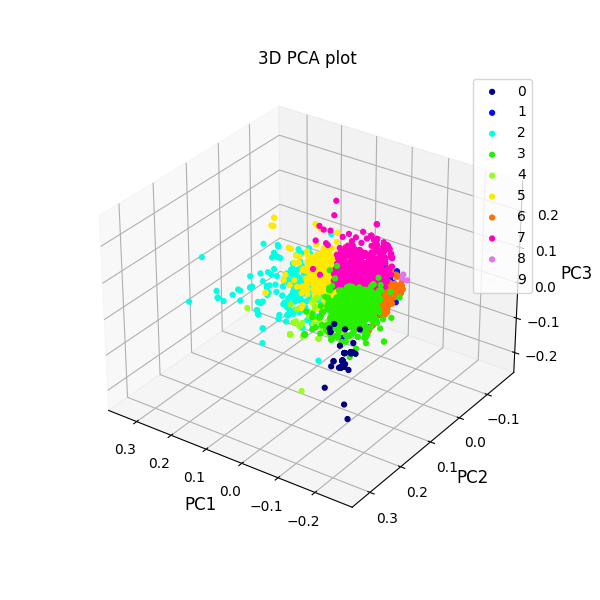

In [37]:
componentes = 3
grupos = 10

# Hacer reduccion de dimensionalidad
# pca = KernelPCA(n_components=componentes, kernel='rbf', gamma=0.1)
pca = PCA(n_components=componentes)
pca.fit(matriz)
X = pca.transform(matriz)

# Hacer clustering
kmeans = KMeans(n_clusters=grupos, n_init='auto')
kmeans.fit(matriz)
G = kmeans.predict(matriz)



X_df = to_df(X, G, indexes=cluster_df_normal.index, columns=[f"PC{i}" for i in range(1, componentes + 1)])
gustos_anime(cluster_df_normal, G, 10)

%matplotlib widget
plot_pca(X_df, "PC1", "PC2", "PC3", "grupo")

In [41]:
X_df[X_df["grupo"] == 9]

,PC1,PC2,PC3,grupo
16752895:Its_alessio,-0.038659,0.043192,-0.011373,9


## iteracion 4

0:
Comedy          0.045305
Action          0.044842
Shounen         0.036420
Fantasy         0.034111
Drama           0.034051
School Life     0.033120
Romance         0.028851
Supernatural    0.020097
Violence        0.020093
Sci Fi          0.017884
Name: 0, dtype: float64

1:
Action               0.078128
Shounen              0.059664
Fantasy              0.044655
Mature Themes        0.034243
Explicit Violence    0.031934
Violence             0.030769
Drama                0.030534
Military             0.027347
Adventure            0.026639
Horror               0.022389
Name: 1, dtype: float64

2:
School Life        0.114505
Romance            0.107105
Drama              0.094550
Comedy             0.073722
Shounen            0.046121
School Club        0.035750
Supernatural       0.028105
Romantic Comedy    0.021525
Seinen             0.018908
Sports             0.017113
Name: 2, dtype: float64

3:
Shounen                0.135304
Action                 0.126195
Drama              

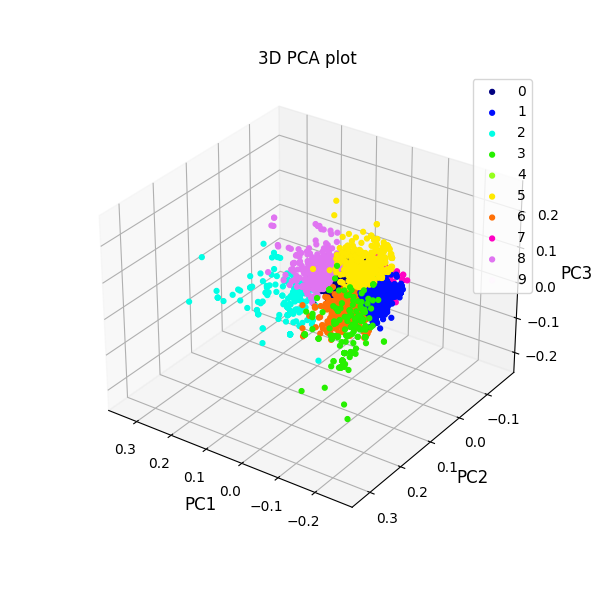

In [43]:
componentes = 3
grupos = 10

# Hacer reduccion de dimensionalidad
# pca = KernelPCA(n_components=componentes, kernel='rbf', gamma=0.1)
pca = PCA(n_components=componentes)
pca.fit(matriz)
X = pca.transform(matriz)

# Hacer clustering
kmeans = KMeans(n_clusters=grupos, n_init='auto')
kmeans.fit(X)
G = kmeans.predict(X)



X_df = to_df(X, G, indexes=cluster_df_normal.index, columns=[f"PC{i}" for i in range(1, componentes + 1)])
gustos_anime(cluster_df_normal, G, 10)

%matplotlib widget
plot_pca(X_df, "PC1", "PC2", "PC3", "grupo")

## iteracion 5

0:
Drama            0.104499
Romance          0.055740
School Life      0.046324
Action           0.034236
Shounen          0.030936
Supernatural     0.028098
Comedy           0.026174
Mature Themes    0.026030
Violence         0.025913
Melancholy       0.024276
Name: 0, dtype: float64

1:
Comedy          0.048898
Action          0.047191
Shounen         0.037307
School Life     0.034583
Drama           0.033069
Fantasy         0.032906
Romance         0.028506
Violence        0.020538
Supernatural    0.019987
Sci Fi          0.019307
Name: 1, dtype: float64

2:
Action           0.067315
Shounen          0.046623
Fantasy          0.041113
Comedy           0.029385
Violence         0.028175
Drama            0.027880
Adventure        0.027728
Sci Fi           0.021261
Mature Themes    0.021190
Supernatural     0.020695
Name: 2, dtype: float64

3:
Fantasy                 0.067232
Comedy                  0.046742
Romance                 0.042217
Magic                   0.035212
School Life

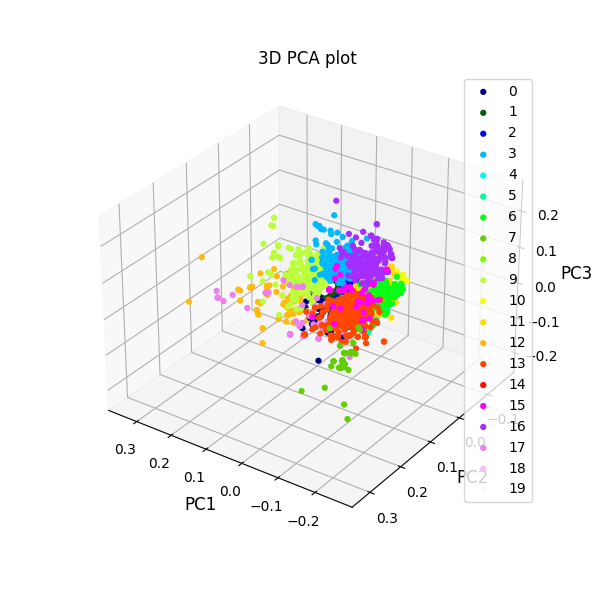

In [56]:
componentes = 7
grupos = 20

# Hacer reduccion de dimensionalidad
# pca = KernelPCA(n_components=componentes, kernel='rbf', gamma=0.1)
pca = PCA(n_components=componentes)
pca.fit(matriz)
X = pca.transform(matriz)

# Hacer clustering
kmeans = KMeans(n_clusters=grupos, n_init='auto')
kmeans.fit(X)
G = kmeans.predict(X)



X_df = to_df(X, G, indexes=cluster_df_normal.index, columns=[f"PC{i}" for i in range(1, componentes + 1)])
gustos_anime(cluster_df_normal, G, 10)

%matplotlib widget
plot_pca(X_df, "PC1", "PC2", "PC3", "grupo")